In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
import cenpy as cp

ox.__version__

'1.1.1'

In [2]:
from pyrosm import OSM, get_data
import osmnx as ox

In [3]:
%time fp = get_data("Florida")
%time osm = OSM(fp)

CPU times: user 479 µs, sys: 383 µs, total: 862 µs
Wall time: 562 µs
CPU times: user 730 µs, sys: 697 µs, total: 1.43 ms
Wall time: 1.1 ms


In [4]:
%time nodes, edges = osm.get_network(nodes=True, network_type="driving")

CPU times: user 5min 11s, sys: 38.9 s, total: 5min 50s
Wall time: 5min 54s


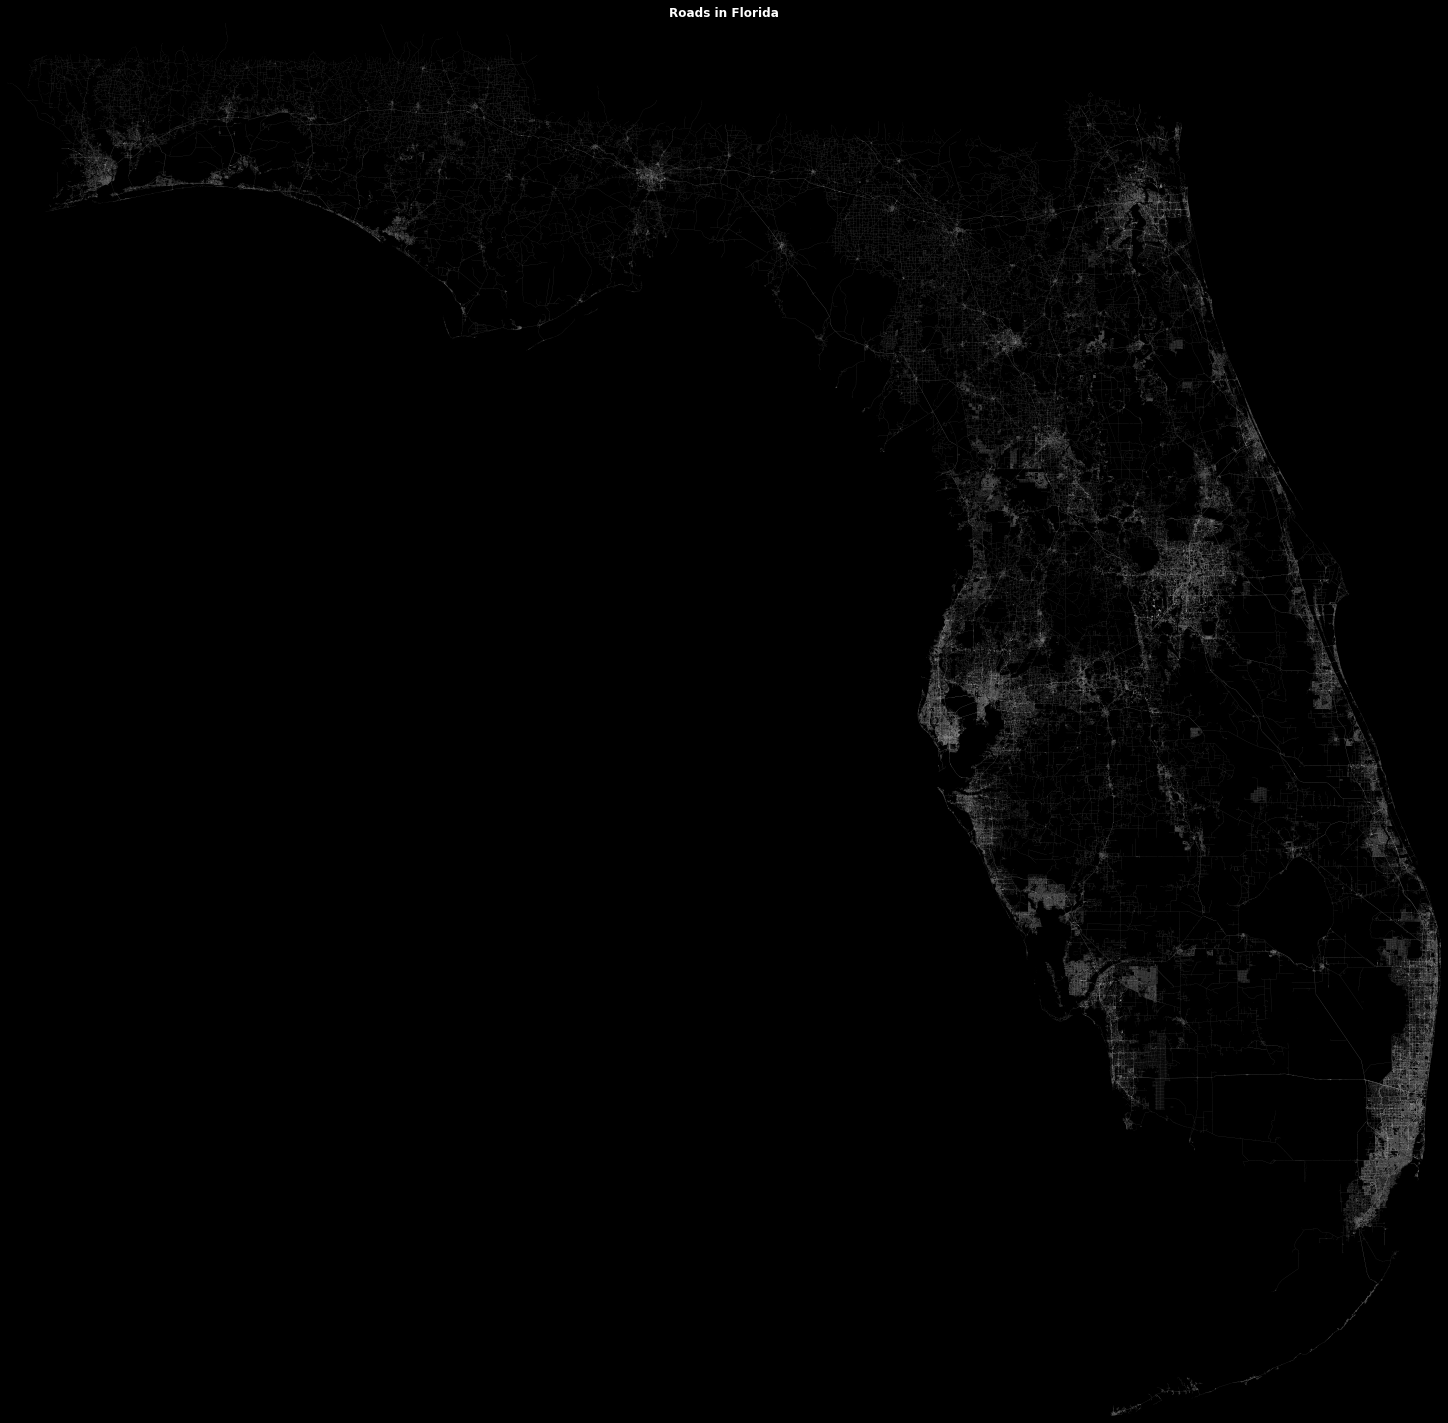

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       facecolor='k',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

edges.plot(ax=ax, color='w', alpha=0.5, lw=0.1)
    
ax.set_title("Roads in Florida", color='w', weight='bold')

ax.set_axis_off()
    
fig.savefig('street-topology-florida.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')

In [6]:
%time G = osm.to_graph(nodes, edges, graph_type="networkx")

CPU times: user 26min 19s, sys: 40min 27s, total: 1h 6min 47s
Wall time: 2h 27min 53s


In [7]:
%%time
att_list = ['geometry']
for n1, n2, d in G.edges(data=True):
    for att in att_list:
        d.pop(att, None)

G = ox.simplify_graph(G)

CPU times: user 27min 49s, sys: 29min 53s, total: 57min 42s
Wall time: 1h 23min 50s


In [8]:
nodes = ox.graph_to_gdfs(G, edges=False)

In [16]:
state = 12
year = 2018

url = f"https://www2.census.gov/geo/tiger/GENZ{year}/shp/cb_{year}_{state}_bg_500k.zip"

<AxesSubplot:>

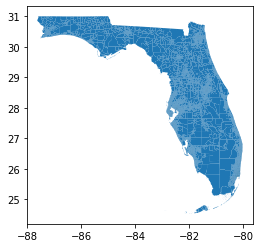

In [17]:
state = gpd.read_file(url)
state.geometry.plot()

In [18]:
state = state.to_crs(nodes.crs)

In [19]:
joined = gpd.sjoin(nodes, state, how='left', predicate='intersects')

In [51]:
from scipy import stats
num_bins = 36
min_bins = 4

threshold = 10

max_entropy = np.log(num_bins)

perfect_grid = [1] * min_bins + [0] * (num_bins - min_bins)
perfect_grid_entropy = stats.entropy(perfect_grid)

In [52]:
def reverse_bearing(x):
    return x + 180 if x < 180 else x - 180

def get_unweighted_bearings(G, threshold):
    # calculate edge bearings
    # threshold lets you discard streets < some length from the bearings analysis
    b = pd.Series([d['bearing'] for u, v, k, d in G.edges(keys=True, data=True) if d['length'] > threshold])
    return pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')

def count_and_merge(n, bearings):
    # make twice as many bins as desired, then merge them in pairs
    # prevents bin-edge effects around common values like 0° and 90°
    n = n * 2
    bins = np.arange(n + 1) * 360 / n
    count, _ = np.histogram(bearings, bins=bins)
    
    # move the last bin to the front, so eg 0.01° and 359.99° will be binned together
    count = np.roll(count, 1)
    return count[::2] + count[1::2]

def calculate_orientation_entropy(data, n):
    bin_counts = count_and_merge(n, data)
    entropy = stats.entropy(bin_counts)
    return entropy

def orientation_order(eta, max_ent=max_entropy, min_ent=perfect_grid_entropy):
    # normalize it as a value between perfect_grid_entropy and max_entropy
    # then square it to approx linearize orientation_order's relationship with the
    # share of total bins with equal non-zero probabilities
    return 1 - ((eta - min_ent) / (max_ent - min_ent)) ** 2

In [53]:
%%time

misses = np.empty(0)
errors = np.empty(0)

results = {}

for i in state.index:
    
    geoid = state['GEOID'][i]
    print(geoid)
    
    poly = state.geometry[i].buffer(0.0001)
    
    try: 
        intersecting_nodes = nodes[nodes.intersects(poly)].index
        G_sub = G.subgraph(intersecting_nodes) 
    except: 
        misses = np.append(misses, geoid)
        pass
    
    nx.set_node_attributes(G_sub, G_sub.degree(), "street_count")
    
    n, e = ox.graph_to_gdfs(ox.add_edge_bearings(G_sub))
    n_stats = n.agg({'street_count': ['count', 'mean']})
    e_stats = e.agg({'length': ['sum', 'count', 'mean']})
    
    bearings = e[e['length'] > threshold]['bearing']
    orientation_entropy = calculate_orientation_entropy(bearings.dropna(), num_bins)
    
    net_stats = ox.stats.basic_stats(G_sub)
    
    order = orientation_order(orientation_entropy)
    
    try: 
        inter = net_stats['streets_per_node_proportions'][4]
    except:
        inter = 0
        errors = np.append(errors, geoid)
        
    lined = 1 / ox.stats.circuity_avg(G_sub.to_undirected())
    
    results[geoid] = {'node_count': n_stats.iloc[0, 0],
                      'typical_intersection': n_stats.iloc[1, 0],
                      'edge_length': e_stats.iloc[2, 0],
                      'edge_count': e_stats.iloc[1, 0],
                      'edge_total': e_stats.iloc[0, 0],
                      'orientation_order': order,
                      'prop_4way': inter,
                      'straightness': lined,
                      'grid_index': stats.gmean([order, inter, lined])}
    
results = pd.DataFrame(results).T

120110101041


TypeError: networkx.classes.multidigraph.MultiDiGraph.add_edge() got multiple values for keyword argument 'key'